In [73]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [74]:
df = pd.read_csv('df_after_data_processing.csv')

In [75]:
df.columns.tolist()[:150]

['DOI',
 'Date',
 'Journal',
 'Title',
 'Name',
 'measurement_method',
 'raw_value',
 'smiles',
 'index',
 'atom_stereo_count',
 'atoms',
 'bond_stereo_count',
 'bonds',
 'cactvs_fingerprint',
 'canonical_smiles',
 'charge',
 'complexity',
 'coordinate_type',
 'covalent_unit_count',
 'defined_atom_stereo_count',
 'defined_bond_stereo_count',
 'elements',
 'exact_mass',
 'fingerprint',
 'h_bond_acceptor_count',
 'h_bond_donor_count',
 'heavy_atom_count',
 'inchi',
 'inchikey',
 'isomeric_smiles',
 'isotope_atom_count',
 'iupac_name',
 'molecular_formula',
 'molecular_weight',
 'monoisotopic_mass',
 'record',
 'rotatable_bond_count',
 'tpsa',
 'undefined_atom_stereo_count',
 'undefined_bond_stereo_count',
 'xlogp',
 'index.1',
 'exactmw',
 'amw',
 'lipinskiHBA',
 'lipinskiHBD',
 'NumRotatableBonds',
 'NumHBD',
 'NumHBA',
 'NumHeavyAtoms',
 'NumAtoms',
 'NumHeteroatoms',
 'NumAmideBonds',
 'FractionCSP3',
 'NumRings',
 'NumAromaticRings',
 'NumAliphaticRings',
 'NumSaturatedRings',
 'NumH

Firstly, let's check lipinskiHBA - number of heteroatoms dependence using scatterplot

<AxesSubplot:xlabel='lipinskiHBA', ylabel='NumHeteroatoms'>

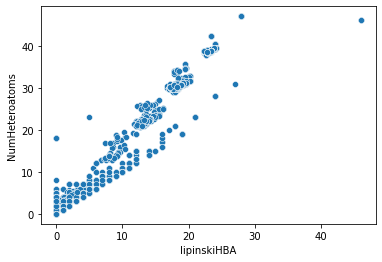

In [76]:
sns.scatterplot(x='lipinskiHBA', y='NumHeteroatoms' ,data=df)

In [77]:
from scipy import stats
stats.pearsonr(df['lipinskiHBA'], df['NumHeteroatoms'])

(0.9879978036920428, 0.0)

As we can see, these descriptors have strong positive correlation

Next, we cal visualize a boxplot of number of atoms in molecules in our dataset

<AxesSubplot:ylabel='NumAtoms'>

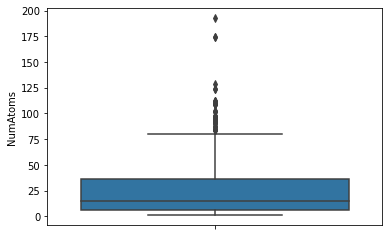

In [78]:
sns.boxplot(data=df, y='NumAtoms')

As we can see our dataset mainly contains small molecules. Also, there are some outliers in this descriptor

We can visualize distribution of molecular weights in our database using histogram plot

<AxesSubplot:xlabel='molecular_weight', ylabel='Count'>

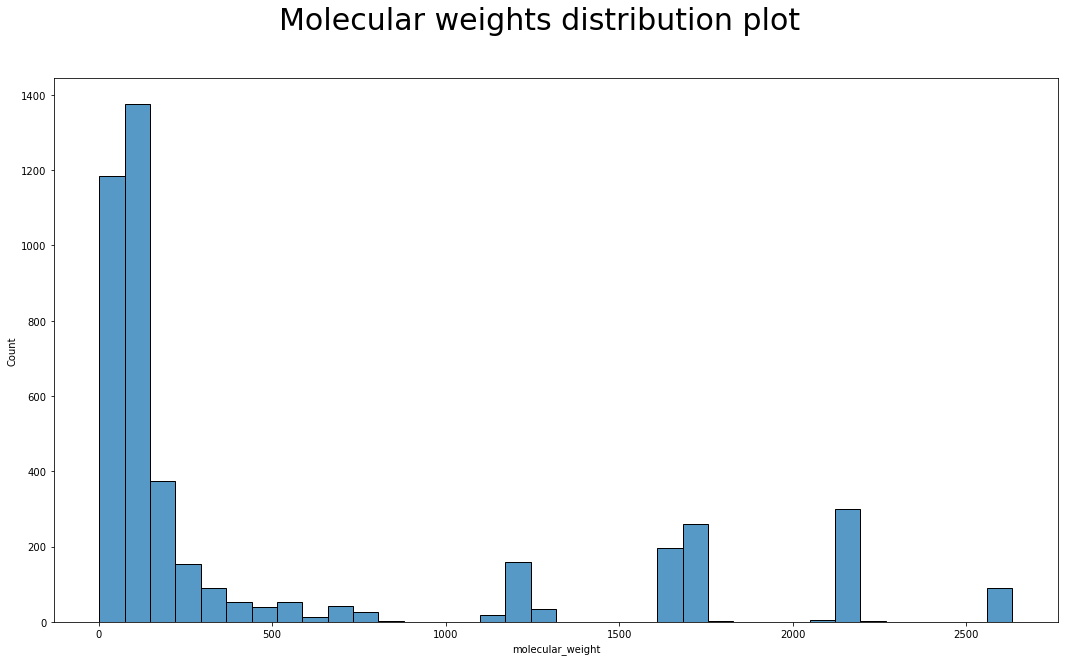

In [79]:
fig, axes = plt.subplots(figsize=(18, 10))

fig.suptitle('Molecular weights distribution plot', size=30)
sns.histplot(data=df, x='molecular_weight')

As we can see, distribution of molecular weights shifted to the small values (because our dataset dominated by small molecules)

Next, we can use plotly to build interactive visualizations

In [80]:
import plotly.graph_objects as go
import plotly.express as px
from jupyter_dash import JupyterDash
from dash import dcc, html
from dash.dependencies import Input, Output 

In [81]:
fig = px.scatter(df, x='CrippenClogP', y='xlogp', size='NumAtoms', size_max=25)
 # build jupyter dash app
app = JupyterDash(__name__)
 # add html components and figure to app
app.layout = html.Div([dcc.Graph(figure=fig)])
 # run app inline
app.run_server(mode='inline')

Dash is running on http://127.0.0.1:8050/



As we can see, small molecules have the approximately the same distribution between octanol and water while large molecules tend to be hydrophilic or hydrophobic. It should be mentioned, that for hydrophobic molecules there is correspondence between two different calculation approaches for obtaining logP value, however for more hydrophilic molecules there is not any compliance between two methods.

As we can see, plots can be useful for understanding distribution of parameters in our dataset or investigation of dependiences between them.

Next, let's take some statistical tests on our data

Shapiro-test<br>
The null-hypothesis of this test is that the population is normally distributed<br>
The alternative hypothesis of this test is that the population is not normally distributed

In [82]:
from scipy.stats import shapiro
data = df['NumAtoms']
stat, p = shapiro(data)
print('stat={0:.3f}, p={1:.3f}'.format(stat, p))
if p > 0.05:
    print('Probably Gaussian')
else:
    print('Probably not Gaussian')

stat=0.854, p=0.000
Probably not Gaussian


<AxesSubplot:xlabel='NumAtoms', ylabel='Count'>

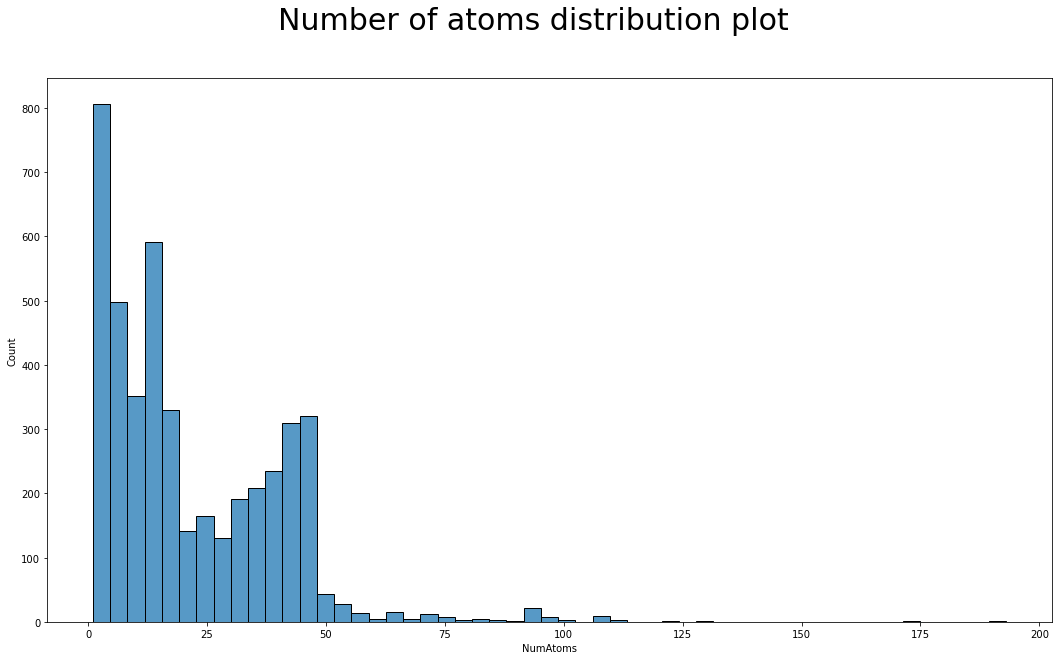

In [83]:
fig, axes = plt.subplots(figsize=(18, 10))

fig.suptitle('Number of atoms distribution plot', size=30)
sns.histplot(data=df, x='NumAtoms')

Our distribution is not Gaussian with data shift towards small molecules

Next we can check, do the molecular weight and number of atoms have the same distribution

t test<br>
The null-hypothesis of this test is that populations have the same distributions<br>
The alternative hypothesis of this test is that populations have different distributions

In [84]:
from scipy.stats import ttest_ind
data1 = df['molecular_weight']
data2 = df['NumAtoms']
stat, p = ttest_ind(data1, data2)
print('stat={0:.3f}, p={1:.3f}'.format(stat, p))
if p > 0.05:
    print('Probably the same distribution')
else:
    print('Probably different distributions')

stat=45.641, p=0.000
Probably different distributions


They have different distribution because of presence of heavy atoms in our molecules 

Let's check distributions of number H acceptors and lipinski HBA (number of Os and Ns)

t test<br>
The null-hypothesis of this test is that populations have the same distributions<br>
The alternative hypothesis of this test is that populations have different distributions

In [85]:
from scipy.stats import ttest_ind
data1 = df['h_bond_acceptor_count']
data2 = df['lipinskiHBA']
stat, p = ttest_ind(data1, data2)
print('stat={0:.3f}, p={1:.3f}'.format(stat, p))
if p > 0.05:
    print('Probably the same distribution')
else:
    print('Probably different distributions')

stat=0.944, p=0.345
Probably the same distribution


<AxesSubplot:xlabel='lipinskiHBA', ylabel='Count'>

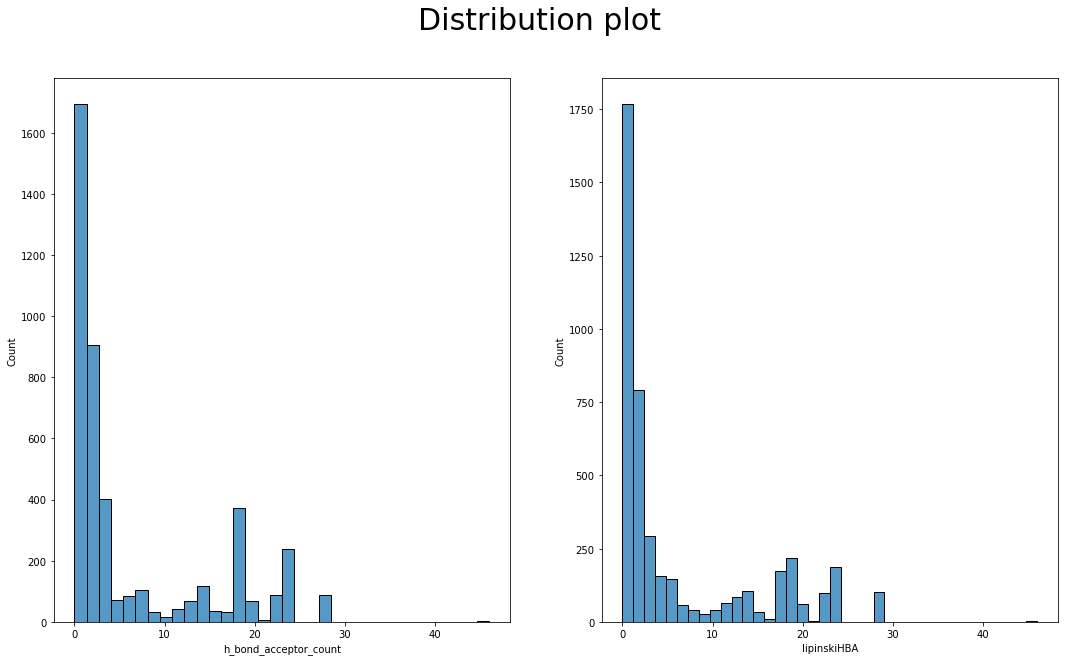

In [86]:
fig, axes = plt.subplots(1, 2, figsize=(18, 10))

fig.suptitle('Distribution plot', size=30)
sns.histplot(ax=axes[0], data=df, x='h_bond_acceptor_count')
sns.histplot(ax=axes[1], data=df, x='lipinskiHBA')

We can conclude that the main atoms that are acceptors of hydrogen in our database are nitrogen and oxygen

It is interesting to investigane distributions of logP values obtained by different calculation methods

ANOVA test<br>
The null-hypothesis of this test is that populations have the same distributions<br>
The alternative hypothesis of this test is that populations have different distributions

In [87]:
from scipy.stats import f_oneway
data1 = df['xlogp']
data2 = df['CrippenClogP']
data3 = df['ALogP']
stat, p = f_oneway(data1, data2)
print('stat={0:.3f}, p={1:.3f}'.format(stat, p))
if p > 0.05:
    print('Probably the same distribution')
else:
    print('Probably different distributions')

stat=1333.643, p=0.000
Probably different distributions


<AxesSubplot:xlabel='ALogP', ylabel='Count'>

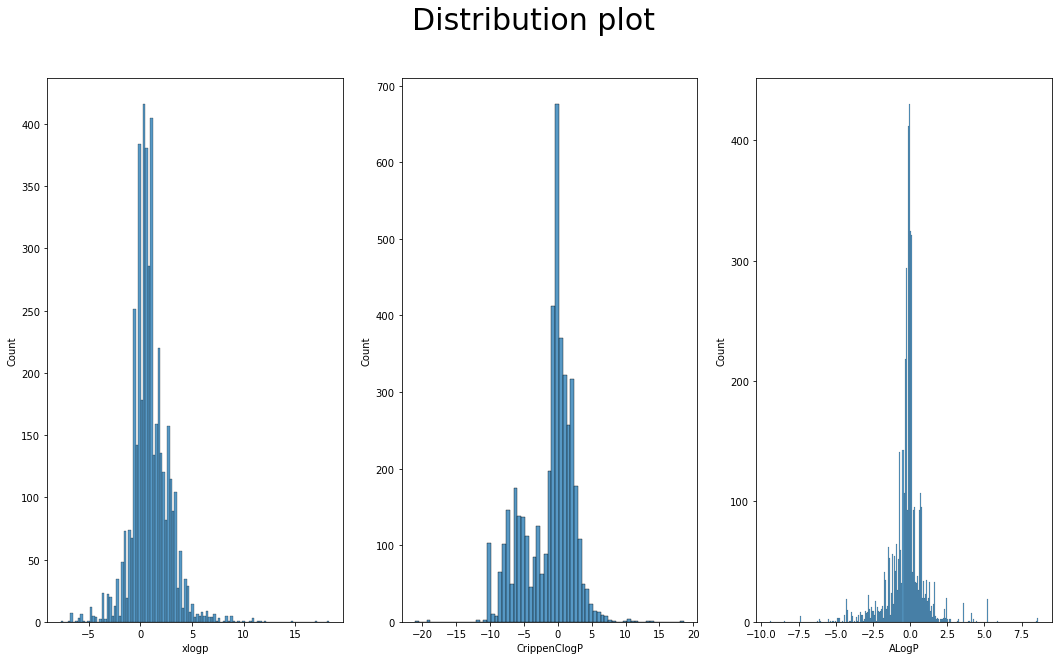

In [88]:
fig, axes = plt.subplots(1, 3, figsize=(18, 10))

fig.suptitle('Distribution plot', size=30)
sns.histplot(ax=axes[0], data=df, x='xlogp')
sns.histplot(ax=axes[1], data=df, x='CrippenClogP')
sns.histplot(ax=axes[2], data=df, x='ALogP')

So, they do not have similar distrubution

Let's translate CrippenClogP from numerical to categorical values

In [89]:
for i,_ in df.iterrows():
    if df['CrippenClogP'][i] < 0:
        df['CrippenClogP'][i] = 'Hydrophilic'
    elif df['CrippenClogP'][i] > 0:
        df['CrippenClogP'][i] = 'Hydrophobic'
    elif df['CrippenClogP'][i] == 0:
        df['CrippenClogP'][i] = 'Superposition'

/tmp/ipykernel_131/4079677703.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



And do some interesting statistics

t test<br>
The null-hypothesis of this test is that populations with different lypophilicity have the same distributions<br>
The alternative hypothesis of this test is that populations with different lypophilicity have different distributions

Hydrophilic v.s. Hydrophobic: t-test independent samples with Bonferroni correction, P_val=5.201e-208 stat=3.249e+01


(<AxesSubplot:xlabel='CrippenClogP', ylabel='h_bond_acceptor_count'>,
 [<statannot.StatResult.StatResult at 0x7fdc656591b0>])

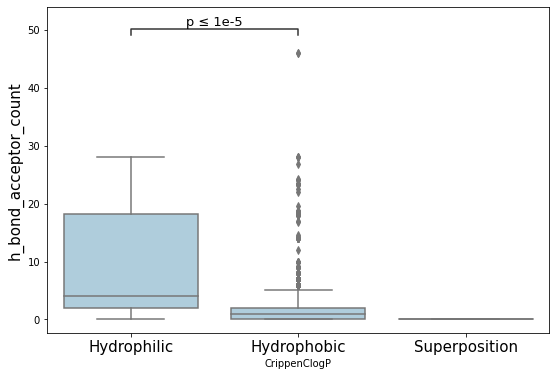

In [90]:
from statannot import add_stat_annotation
f, g = plt.subplots(figsize=(9, 6))
g = sns.boxplot(x='CrippenClogP', y='h_bond_acceptor_count', data=df, color='#A7D0E4')
g.set_ylabel( r'h_bond_acceptor_count', fontsize = 15)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 15)
add_stat_annotation(g, data=df, x='CrippenClogP', y='h_bond_acceptor_count',
                    box_pairs=[('Hydrophobic', 'Hydrophilic')],
                    test='t-test_ind', text_format='simple', loc='inside', verbose=2, fontsize = 13, comparisons_correction='bonferroni')

As we can see, there is significant difference in number of h acceptors between hydrophilic and hydrophobic molecules

t test<br>
The null-hypothesis of this test is that populations with different lypophilicity have the same distributions<br>
The alternative hypothesis of this test is that populations with different lypophilicity have different distributions

Hydrophilic v.s. Hydrophobic: t-test independent samples with Bonferroni correction, P_val=3.106e-176 stat=2.963e+01


(<AxesSubplot:xlabel='CrippenClogP', ylabel='kappa1'>,
 [<statannot.StatResult.StatResult at 0x7fdc65553490>])

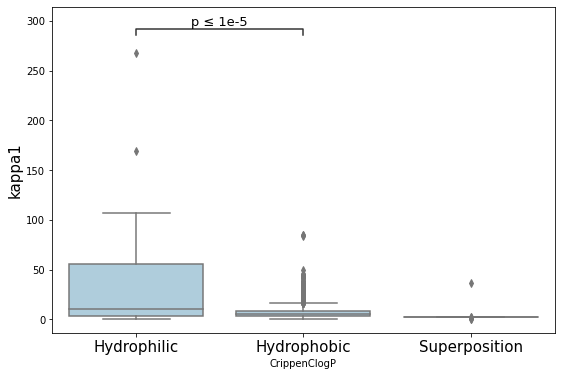

In [92]:
from statannot import add_stat_annotation
f, g = plt.subplots(figsize=(9, 6))
g = sns.boxplot(x='CrippenClogP', y='kappa1', data=df, color='#A7D0E4')
g.set_ylabel( r'kappa1', fontsize = 15)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 15)
add_stat_annotation(g, data=df, x='CrippenClogP', y='kappa1',
                    box_pairs=[('Hydrophobic', 'Hydrophilic')],
                    test='t-test_ind', text_format='simple', loc='inside', verbose=2, fontsize = 13, comparisons_correction='bonferroni')

What is more interesting that complexity of the structure is different for hydrophobic and hydrophilic molecules in our dataset. 
More branched molecules are hydrophobic

Now let's check a correlation between all our descriptors. We will use spearman correlation method for that.

In [4]:
df = pd.read_csv('df_after_data_processing.csv')
corr_all = df.corr(method='spearman', numeric_only=True)
corr_all.dropna(how='all', axis=1, inplace = True)
corr_all.dropna(how='all', axis=0, inplace = True)
corr_all

,measurement_method,raw_value,atom_stereo_count,bond_stereo_count,charge,complexity,covalent_unit_count,defined_atom_stereo_count,defined_bond_stereo_count,exact_mass,...,AMW,WTPT-1,WTPT-2,WTPT-3,WTPT-4,WTPT-5,WPATH,WPOL,XLogP,Zagreb
measurement_method,1.000000,0.052219,-0.045642,-0.010156,0.011293,-0.042614,0.018090,-0.029510,-0.013151,-0.010736,...,0.130875,-0.008824,-0.084733,0.083352,0.064525,-0.053829,0.004089,-0.022479,-0.095995,-0.014852
raw_value,0.052219,1.000000,0.141369,0.005053,0.069015,0.163462,0.338159,0.001183,0.001712,0.377151,...,0.482053,0.312533,0.010431,0.403505,0.349400,0.096897,0.333081,0.270991,-0.268495,0.294703
atom_stereo_count,-0.045642,0.141369,1.000000,0.096058,0.022000,0.559315,0.268980,0.536482,0.098764,0.446707,...,0.173590,0.445667,0.234405,0.379210,0.384631,0.233000,0.377011,0.492186,-0.251337,0.473274
bond_stereo_count,-0.010156,0.005053,0.096058,1.000000,0.055997,0.159289,-0.058993,0.179847,0.958119,0.061594,...,-0.063555,0.080202,0.127398,-0.007509,-0.004731,0.070599,0.035371,0.119308,0.113882,0.102246
charge,0.011293,0.069015,0.022000,0.055997,1.000000,-0.080298,0.109728,0.050188,0.049224,-0.018412,...,0.052413,0.083847,0.019739,0.073390,0.037028,0.069893,0.092563,0.089597,-0.055242,0.080182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WTPT-5,-0.053829,0.096897,0.233000,0.070599,0.069893,0.322670,0.133688,0.215518,0.068245,0.220861,...,0.028210,0.269094,0.206430,0.233629,0.133838,1.000000,0.206551,0.301054,-0.062542,0.289554
WPATH,0.004089,0.333081,0.377011,0.035371,0.092563,0.470062,0.725742,0.080627,0.033828,0.746174,...,0.593577,0.896998,0.262912,0.772073,0.764685,0.206551,1.000000,0.813390,-0.455543,0.855558
WPOL,-0.022479,0.270991,0.492186,0.119308,0.089597,0.678750,0.425454,0.302319,0.112032,0.712121,...,0.325720,0.933477,0.591591,0.675303,0.684416,0.301054,0.813390,1.000000,-0.270798,0.955756
XLogP,-0.095995,-0.268495,-0.251337,0.113882,-0.055242,0.001472,-0.539438,-0.033041,0.102702,-0.294255,...,-0.630350,-0.385098,0.311627,-0.719246,-0.741128,-0.062542,-0.455543,-0.270798,1.000000,-0.335988


We can visualize it with heatmap.

<Axes: >

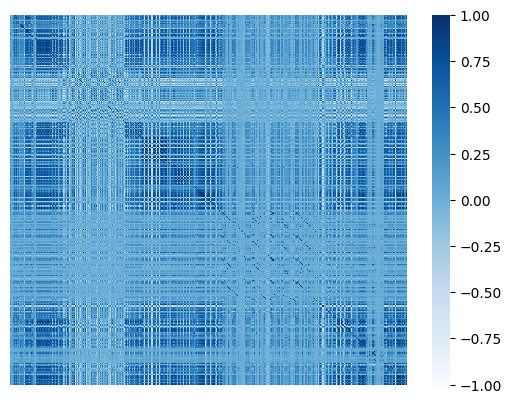

In [5]:
sns.heatmap(corr_all, cmap="Blues", xticklabels=False, yticklabels=False)

Ass we can see, there are many strong correlations.<br>
Let's fix it by limit correlation coefficient between -0.3 and 0.3.

In [6]:
df = pd.read_csv('df_after_data_processing.csv')
corr = df.corr(method='spearman', numeric_only=True).abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.3)]
df.drop(to_drop, axis=1, inplace=True)
corr1 = df.corr(method='spearman', numeric_only=True)
corr1.dropna(how='all', axis=1, inplace = True)
corr1.dropna(how='all', axis=0, inplace = True)
corr1

,measurement_method,raw_value,atom_stereo_count,bond_stereo_count,charge,isotope_atom_count,xlogp,NumSpiroAtoms,nB,nP,...,nssS,ndssS,ndsssAs,ndSe,SHsSH,maxssssC,n8Ring,n12Ring,nG12Ring,nF4Ring
measurement_method,1.000000,0.052219,-0.045642,-0.010156,0.011293,0.005860,-0.048433,0.039634,-0.017858,0.024321,...,-0.009058,-0.013035,0.000724,0.000512,-0.005034,-0.057508,0.000512,-0.019709,-0.025996,0.019249
raw_value,0.052219,1.000000,0.141369,0.005053,0.069015,-0.032963,0.125601,0.036403,0.100540,0.050430,...,0.041512,0.007429,0.009590,0.010156,0.001320,-0.034022,0.007732,0.001763,-0.021301,0.054244
atom_stereo_count,-0.045642,0.141369,1.000000,0.096058,0.022000,0.009340,0.016311,0.005498,0.084374,0.103588,...,0.117486,-0.015397,-0.009732,-0.006881,-0.016596,0.048599,-0.006881,-0.006881,0.044994,-0.016864
bond_stereo_count,-0.010156,0.005053,0.096058,1.000000,0.055997,0.136326,0.141523,-0.008344,-0.013580,0.004706,...,0.258926,-0.011965,-0.002510,-0.001775,0.001479,0.059925,-0.001775,-0.001775,0.111747,-0.004350
charge,0.011293,0.069015,0.022000,0.055997,1.000000,0.074621,0.054685,-0.016022,0.069463,0.007212,...,-0.026355,-0.003283,-0.049196,0.066738,0.000406,0.005970,-0.000487,-0.000487,0.030527,0.169149
isotope_atom_count,0.005860,-0.032963,0.009340,0.136326,0.074621,1.000000,-0.019955,-0.005485,-0.000154,0.005397,...,-0.006726,-0.007865,-0.001650,-0.001167,0.000972,-0.008378,-0.001167,-0.001167,-0.002610,-0.002859
xlogp,-0.048433,0.125601,0.016311,0.141523,0.054685,-0.019955,1.000000,0.046060,0.042072,-0.092642,...,0.005358,-0.103309,0.001965,-0.005639,0.013375,0.116045,0.008916,0.004623,0.050508,-0.032182
NumSpiroAtoms,0.039634,0.036403,0.005498,-0.008344,-0.016022,-0.005485,0.046060,1.000000,0.002540,-0.011483,...,-0.006068,-0.007095,-0.001489,-0.001052,0.000877,-0.007559,-0.001052,-0.001052,-0.002354,0.084479
nB,-0.017858,0.100540,0.084374,-0.013580,0.069463,-0.000154,0.042072,0.002540,1.000000,0.198136,...,-0.017259,-0.020181,-0.004234,-0.002994,0.002494,-0.021499,-0.002994,-0.002994,-0.006697,-0.007337
nP,0.024321,0.050430,0.103588,0.004706,0.007212,0.005397,-0.092642,-0.011483,0.198136,1.000000,...,0.002398,-0.016466,-0.003455,-0.002442,0.028192,-0.017541,-0.002442,0.094057,-0.005464,-0.005986


Now we have only 41 desriptors that don't correlate between each other.<br>
Let's visualize it too.

<Axes: >

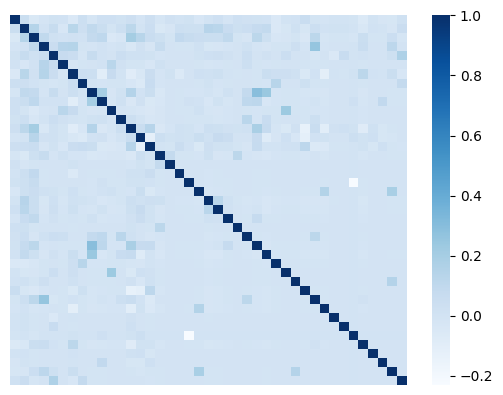

In [7]:
sns.heatmap(corr1, cmap="Blues", xticklabels=False, yticklabels=False)

Next step will be an investigation of multicollinearity of our data.<br>
For that we will find a variance inflation factor measure.<br>
Firstly let's find VIFs for entire dataframe.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
df = pd.read_csv('df_after_data_processing.csv')
num = df.select_dtypes(include='float64').columns
X = df[num]
vif_df1 = pd.DataFrame()
vif_df1['descriptor'] = X.columns
vif_df1['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_df1)

c:\Users\nikit\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\regression\linear_model.py:1752: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\nikit\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


               descriptor       VIF
0       atom_stereo_count  0.951890
1       bond_stereo_count  0.993691
2                  charge  0.999960
3              complexity  0.817512
4     covalent_unit_count  0.515715
...                   ...       ...
1467               WTPT-5  0.910196
1468                WPATH  0.719643
1469                 WPOL  0.637157
1470                XLogP  0.999969
1471               Zagreb  0.474445

[1472 rows x 2 columns]


Let's visualize that information.

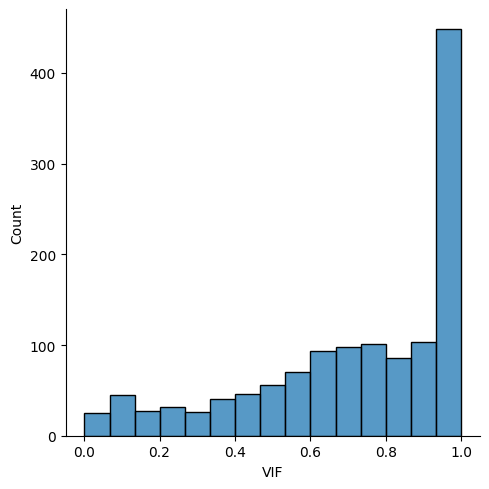

In [ ]:
sns.displot(vif_df1['VIF'], bins = 15, kde = False)
plt.show()

As we can see our VIFs are between 0 and 1 that tells us that we don't have multicollinearity.

Then we will do linear and non-linear dimension reduction method.<br>
As linear method we will use singular value decomposition.

In [97]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import TruncatedSVD

In [121]:
df = pd.read_csv('df_after_data_processing.csv')

Let's choose the number of components that give us 95% variance of the data

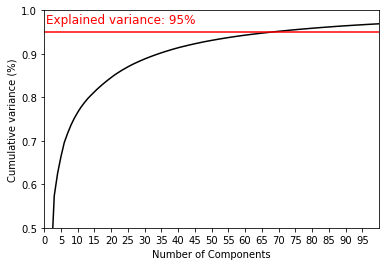

In [147]:
svd = TruncatedSVD(n_components=100, random_state=42)
X = MinMaxScaler().fit_transform(df[num])
X_reduced = svd.fit(X)

#сalculate cumulative variance
y = np.cumsum(svd.explained_variance_ratio_)

#сalculate principal components
xi = np.arange(1, y.shape[0]+1, step=1)

#зlot results
plt.ylim(0.5,1)
plt.xlim(0.0,100)
plt.plot(xi, y, linestyle='-', color='black')
plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 100, step=5))
plt.ylabel('Cumulative variance (%)')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.97, 'Explained variance: 95%', color = 'red', fontsize=12)
plt.show()

As we can see, we should use 70 components

In [148]:
transformer = TruncatedSVD(n_components=70, random_state=0)
SVD_fit = transformer.fit_transform(X)
SVD_df = pd.DataFrame(data = SVD_fit)
SVD_df

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
0,9.453386,-1.648271,-2.118403,0.523892,2.881971,2.789324,-0.299270,-0.171984,-0.452706,0.404846,...,-0.079690,0.073558,0.177548,-0.028741,0.205679,0.023930,-0.220965,0.191739,0.110025,-0.234429
1,12.814496,4.317082,-0.005025,-0.155889,0.028380,0.108119,0.171841,-0.529418,0.539106,-0.361618,...,0.004157,-0.089486,0.061012,-0.105656,0.084224,-0.114785,-0.140704,0.091938,-0.139928,0.054650
2,13.084422,-0.526458,4.941774,2.538902,0.362380,-0.615395,-1.191907,0.346007,0.424133,-0.053362,...,0.625189,-0.333016,0.056615,0.554753,0.380618,-0.372112,-0.175323,0.392518,0.005788,0.212741
3,10.912491,-1.543044,-0.681658,0.506308,1.298257,-0.236396,0.292455,0.162052,-0.138976,-0.207403,...,-1.088823,0.108595,-0.428258,-0.318475,0.239685,0.691932,-0.270386,0.503470,0.262855,-0.448495
4,10.890045,-2.903430,-0.039477,-1.785794,-0.866190,0.556188,-0.579896,-0.155791,-0.075280,-0.126000,...,0.036422,0.069693,0.011276,0.107981,-0.069972,0.110214,0.118701,0.001722,-0.049701,-0.058158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4463,10.536767,-2.754229,-1.414608,-0.844619,-0.682557,0.140968,0.117056,1.146006,0.879271,0.331207,...,-0.278539,-0.179373,0.046045,0.185859,-0.043853,-0.195758,-0.118359,0.069954,0.091548,0.068175
4464,10.712171,-2.385703,-1.308619,0.103992,-0.601955,-0.571072,-0.220565,0.145596,0.393080,-0.340253,...,0.091419,-0.139447,0.093431,-0.381816,0.036922,0.508138,0.109306,-0.032079,-0.238371,-0.071114
4465,12.085439,-1.398810,2.504064,0.126144,-1.252394,-0.067241,-0.638519,-1.912050,-1.074274,-0.533206,...,0.315742,0.194189,0.451992,0.007318,-0.238410,-0.019638,0.090196,0.249253,-0.486939,-0.041122
4466,11.214638,-2.603696,0.115610,-1.653789,-0.725635,0.418004,-0.323676,-0.026897,-0.035036,-0.106071,...,-0.097251,-0.053756,0.005193,0.284551,-0.042924,-0.022767,0.151061,0.023016,-0.156389,-0.104508


Let's visualize projections of our data on the first 10 pairs of components by making a scatter plot and adding dependence of number of atoms.

<AxesSubplot:xlabel='8', ylabel='9'>

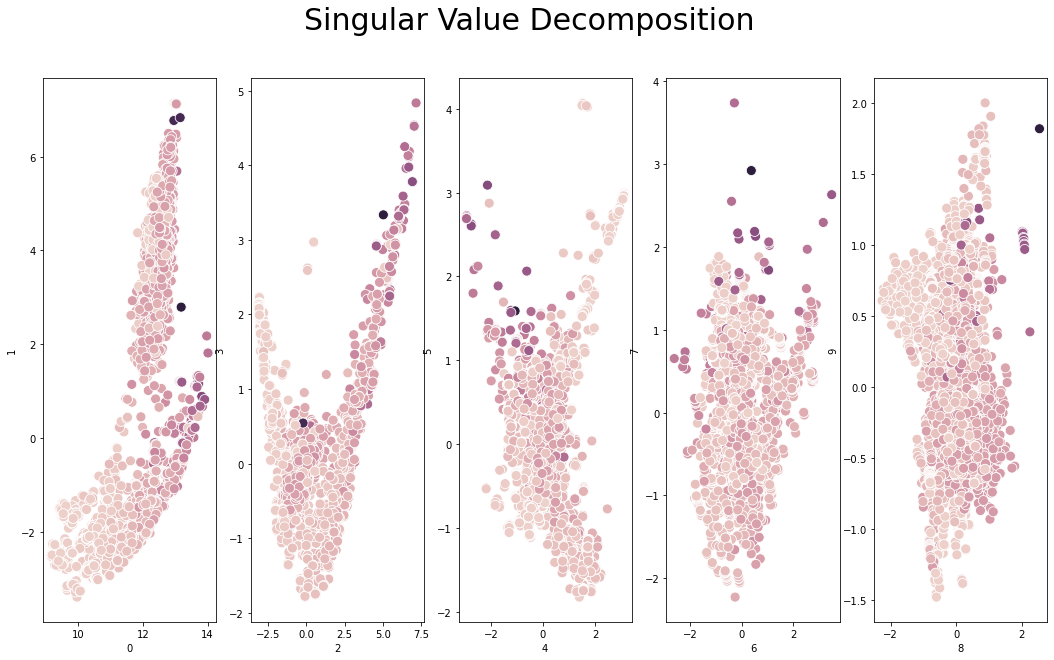

In [179]:
fig, axes = plt.subplots(1, 5, figsize=(18, 10))
fig.suptitle('Singular Value Decomposition', size=30)
sns.scatterplot(ax = axes[0], x=0, y=1, data=SVD_df, hue = df['NumAtoms'], legend=False, s=100)
sns.scatterplot(ax = axes[1], x=2, y=3, data=SVD_df, hue = df['NumAtoms'], legend=False, s=100)
sns.scatterplot(ax = axes[2], x=4, y=5, data=SVD_df, hue = df['NumAtoms'], legend=False, s=100)
sns.scatterplot(ax = axes[3], x=6, y=7, data=SVD_df, hue = df['NumAtoms'], legend=False, s=100)
sns.scatterplot(ax = axes[4], x=8, y=9, data=SVD_df, hue = df['NumAtoms'], legend=False, s=100)

Next we will use nonlinear method. We choose t-Distributed Stochastic Neighbor Embedding, as we have high dimensional dataset.

In [67]:
from sklearn.manifold import TSNE

In [68]:
df = pd.read_csv('df_after_data_processing.csv')
num = df.select_dtypes(include='float64').columns
MMscaler = MinMaxScaler()
X = MMscaler.fit_transform(df[num])
tsne = TSNE(n_components=2, random_state=0)
tsne_fit= tsne.fit_transform(X)
tSNE_df = pd.DataFrame(data = tsne_fit, columns = ['tSNE1', 'tSNE2'])
tSNE_df

,tSNE1,tSNE2
0,1.566779,-35.389660
1,38.674793,-12.047639
2,23.203812,44.811417
3,-47.145432,28.148354
4,-45.554306,12.850944
...,...,...
4463,-42.370117,-8.537413
4464,-46.493248,-2.980589
4465,-8.879007,47.718945
4466,-43.591850,9.740044


Now let's visualize it the same way we did it for linear method.

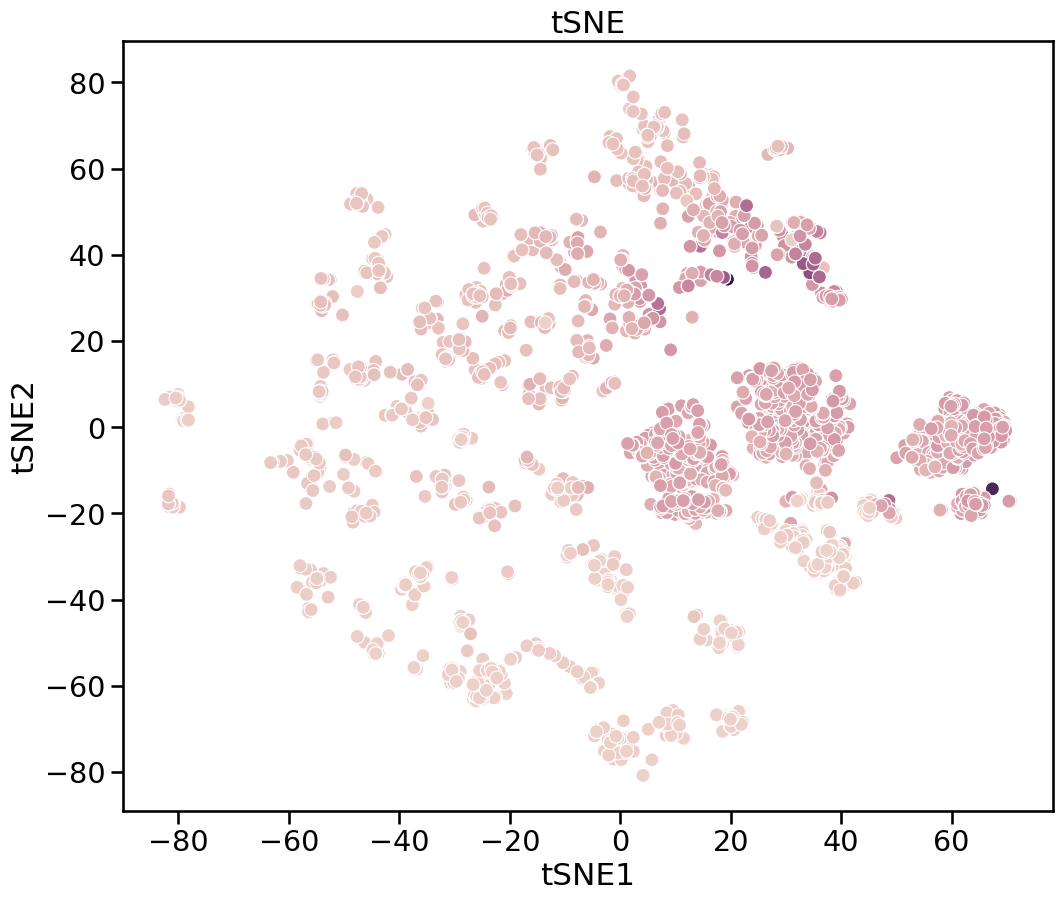

In [14]:
plt.figure(figsize=(12,10))
with sns.plotting_context("talk",font_scale=1.25):
    sns.scatterplot(x="tSNE1", y="tSNE2", data=tSNE_df, hue = df['NumAtoms'], legend=False, s=100)
    plt.xlabel("tSNE1")
    plt.ylabel("tSNE2")
    plt.title("tSNE")